# HR - Hvilke ansatte kommer til å slutte? - Tensorflow

Datasettet er tatt fra https://www.kaggle.com/ludobenistant/hr-analytics


## Intro
Vi ønsker å lage en modell som med god treffsikkert greier å forutse hvilke ansatte som kommer til å forlate selskapet i nærmeste fremtid.




In [259]:
import tensorflow as tf

import numpy as np

import pandas as pd

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold, train_test_split

In [260]:
# Les inn datasettet i en Pandas DataFrame
hr_data = pd.read_csv('data/HR_comma_sep.csv')

In [261]:
# Shuffel datasettet så det ikke ligger sortert.
hr_data = hr_data.sample(frac=1).reset_index(drop=True)

In [262]:
hr_data.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.57,0.90,3,256,4,0,0,0,RandD,low
1,0.21,0.81,4,227,5,0,0,0,marketing,medium
2,0.63,0.50,4,172,2,0,0,0,technical,low
3,0.45,0.54,2,138,3,0,1,0,technical,medium
4,0.64,0.94,3,150,2,0,0,0,technical,medium
5,0.71,0.71,4,221,3,0,0,0,technical,low
6,0.39,0.56,2,156,3,0,1,0,IT,low
7,0.69,0.98,4,180,3,0,0,0,support,medium
8,0.44,0.61,3,147,4,0,0,0,RandD,low
9,0.92,0.68,4,178,3,0,0,0,product_mng,low


In [263]:
# 14999 rader (observasjoner) , 10 kolonner (features)
hr_data.shape

(14999, 10)

In [264]:
hr_data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [265]:
hr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Endre input data
Mange maskinlæringsalgoritmer er svake på å jobbe med String. Nevrale Nettverk er blant dem så vi må mappe om stringene. Vi mapper om alle strings til nummere som referer til hver sin string for en feature. F.eks så blir 'low' i 'salary' featuren til 0.

In [266]:
hr_data['sales'].unique(),hr_data['salary'].unique()

(array(['RandD', 'marketing', 'technical', 'IT', 'support', 'product_mng',
        'sales', 'accounting', 'management', 'hr'], dtype=object),
 array(['low', 'medium', 'high'], dtype=object))

In [267]:
# Modellen vi skal bruke kan ikke håndtere String verdier så vi gjør dem om til numersike verdier. 
# Gjør om featuren (kolonnen) "sales" og featuren "salary".

hr_data['sales'].replace(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
        'IT', 'product_mng', 'marketing', 'RandD'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], inplace = True)

hr_data['salary'].replace(['low', 'medium', 'high'], [0, 1, 2], inplace = True)

## Korrelasjon
Før vi begynner å lage en modell kan det være interessant å se litt nærmere på datasettet. Her har jeg laget en liten korrelasjonsmatrise slik at vi kan se på de linære forholdene mellom de forskjellige featurene i datasettet.



,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,-0.388375,0.025605,0.015413,0.050022
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,0.006567,-0.008684,0.011855,-0.013002
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,0.023787,-0.006064,0.005577,-0.001803
average_montly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,0.071287,-0.003544,-0.002387,-0.002242
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.144822,0.067433,-0.001611,0.048715
Work_accident,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,-0.154622,0.039245,0.019215,0.009247
left,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,1.000000,-0.061788,-0.043814,-0.157898
promotion_last_5years,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,-0.061788,1.000000,0.015170,0.098119
sales,0.015413,0.011855,0.005577,-0.002387,-0.001611,0.019215,-0.043814,0.015170,1.000000,0.033415
salary,0.050022,-0.013002,-0.001803,-0.002242,0.048715,0.009247,-0.157898,0.098119,0.033415,1.000000


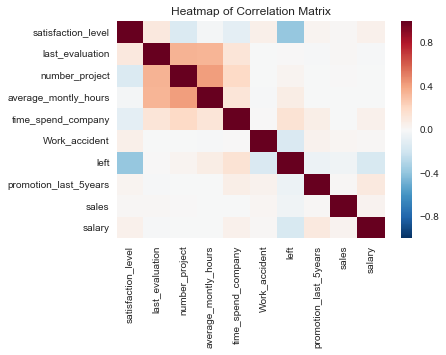

In [268]:
# Korrelasjon Matrise
corr = hr_data.corr()
corr = (corr)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
sns.plt.title('Heatmap of Correlation Matrix')
corr

In [269]:
# Ser her kun på "label som er left" fordi det er den verdien vi ønsker å se features effekt på.
# Korelasjonmatrisen viser kun linære forhold mellom "left" og de andre avhengige variablene.
corr_left = pd.DataFrame(corr['left'].drop('left'))
corr_left.sort_values(by = 'left', ascending = False)

,left
time_spend_company,0.144822
average_montly_hours,0.071287
number_project,0.023787
last_evaluation,0.006567
sales,-0.043814
promotion_last_5years,-0.061788
Work_accident,-0.154622
salary,-0.157898
satisfaction_level,-0.388375


Over kan vi se det linære forholdet mellom våre features og "left". Ikke overraskende så korrelerer "satisfaction_level" negativt med "left"



# Tensorflow Neural Network Model

## Splitting av dataset

For å bygge en maksinkæringsmodell ønsker man å dele opp datasett inn i et treningsett og testsett. Treningsettet brukes til å trene opp modellen, mens testsett brukes for å teste treffsikkerheten til modellen. Her har jeg valgt å dele inn datasette 80% trening og 20% test.

I mange maskinslæringsmodeller er det også vanlig å ha med et validersinsett. Dette sette brukes til å sette/tune hyperparametere (f.eks læringsrate).
For simpelhetens skyld dropper vi å ta med valideringsett her da det ikke spiller noen viktige rolle i denne tutorialen. 



In [270]:
#Train-Test split. Splitter 
from sklearn.model_selection import train_test_split



Siden vi ønsker å finne ut av hvilke ansatt sannsynligvis snart slutter(left), så må vi "ta ut" "left" kolonnen fra datasette. Dette blir da den avhengige variabelen i modellen.

In [271]:
label = hr_data.pop('left')

In [272]:
data_train, data_test, label_train, label_test = train_test_split(hr_data, label, test_size = 0.2, random_state = 42)

In [273]:
# Titter bare på de første elementene i det "nye" datasettet uten "left" kolonnen
data_train.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary
9838,0.41,0.45,2,150,3,0,0,4,1
7689,0.63,0.91,4,252,3,1,0,4,1
6557,0.65,0.95,3,266,3,1,0,4,0
6872,0.67,0.83,3,220,3,0,0,0,0
820,0.86,0.69,5,157,4,0,0,4,0


In [274]:
# Gjør om Pandas DataFrame til python arrays da de er letter å jobbe med. 
x_train = data_train.values
x_test = data_test.values
y_train = label_train.values
y_test_cls  = label_test.values

In [275]:
# 8999 rader med inputs. 9 kolonner med features
print ("Shape X-train: ", data_train.shape)
print ("Shape Y-train: ", label_train.shape)
print ("Shape X-test: ", data_test.shape)
print ("Shape Y-test: ", label_test.shape)

label_train = pd.DataFrame(label_train.values.reshape((11999,1)))
label_test = pd.DataFrame(label_test.values.reshape((3000,1)))
print ("Shaper new label train: {}".format(label_train.shape))
print ("Shaper new label test: {}".format(label_test.shape))

Shape X-train:  (11999, 9)
Shape Y-train:  (11999,)
Shape X-test:  (3000, 9)
Shape Y-test:  (3000,)
Shaper new label train: (11999, 1)
Shaper new label test: (3000, 1)


## Placeholders

Som nevnt tidligere er placeholeder containere/arrays som ikke inneholder noen verdi før en Tensorflow Session blir kjørt og man fyllter opp placeholderene med verdier. Placeholderen kan få inn forksjellige inputs(data) ved hver kjøring og det skjer ingen tuning eller optimering av disse. 

Før vi definerer placeholdere må vi bestemme oss for hvor mange "layers" det skal være i nettverkt, og hvor mange hidden units som skal være i hvert layer. Her har jeg valgt å gjøre det enklest mulig. Det er kun 1 hidden layer, og i dette layer så ligger det 9 noder, som er like mange noder som det er i input layer.

I input layer er det alltid like mange noder som er features i modellen, så vi stter antall kolonner i placeholder til antall features. Antall rader setter vi til "None" noe som betyr at man kan fylle opp placeholderen med et vilkårlig antall ansatt-data.

Input data er i dette tilfelle data for 1 ansatt/person.


In [276]:
# La oss velge layers. 9 input_units, en for hver feature. 9 hidden er valgt random, for simplicity.
# La oss lage en konstant som holder antall features.
ANTALL_FEATURES = 9
input_units = 9
HIDDEN_UNITS = 9
OUTPUT_UNITS = 2

In [277]:
# Siden X(inputs) ikke skal forandres/tunes så lager vi en Placeholder for disse verdiene
# Placeholders er for verdier som skal/kan endres for hver kjøring av grafen.
# Placeholders blir det ikke regner Gradien (partiel deriverte) for 

# Bruke "None" som man kan ha et ukjent antall observasjon/rader inn til X
x_placeh = tf.placeholder(tf.float32, shape=[None, ANTALL_FEATURES])

In [278]:

y_placeh = tf.placeholder(tf.float32, shape=[None,OUTPUT_UNITS])

In [279]:
y_true_cls_placeh = tf.placeholder(tf.int64, [None])

In [280]:
# Konvertere heltall verdi til forskjellige klassifiseringer. 1 blir [1,0] og 0 blir [0, 1] 
def dense_to_one_hot(labels_dense, num_classes=10):
    
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    
    return labels_one_hot

In [281]:
y_hot_train = dense_to_one_hot(y_train, 2)
y_hot_test = dense_to_one_hot(y_test_cls, 2)


## Weights og Biases
Setter default weights/koefisientene for datasettet. Random verdi mellom -1 og 1. Alle verdier like sannsynlig.

Vektene er hva som ligger på edges(kantene) fra en node i et lag, si (n-layer), til alle noden i lag (n-layer+1)
Siden vi har 9 features, har vi 9 input noder. Siden hver input node har 9 kanter, så får vi totalt her 9*9 weights og kanter fra input layer til hidden layer. 

Hver rad i (input_units, hidden_units) kan man se på som weights for kantene for en input_node mot hidden_layer. Siden det er 9 kanter ut fra hver input node, så får vi 9 kolonner i hver rad. Så weights matrisen har shape (9, 9) mot hidden layer.

Fra hidden layer til output_layer får vi matrise (9, 2) siden det er 9 noder i hidden layer og 2 i output layer. 

Jeg har valgt å bruke 2 classifications for "left". En for om den ansatte har forlatt bedriften, og en for om ansatte ikke har forlatt. 
(PS: Det finnes andre kanskje bedre måter å gjøre dette på når det er binær classification. Jeg fikk det bare ikke til å virke særlig bra.....)

### Variabler T.F
Weights og Biases er variabler fordi de skal optimeres/tunes for å gjøre modellen bedre. Gjennom flere kjøring gjennomgrafen innenfor samme Session, så vil disse Variable endre verdi. Verdiene blir endret basert på en kostnadsverdi som sier noe om hvor god modellen vår er til å predikere datasettet. Kommer tilbake til dette litt lenger ned. 

In [282]:

weights = {
    'hidden': tf.Variable(tf.random_uniform((ANTALL_FEATURES, HIDDEN_UNITS), -1, 1), dtype=tf.float32),
    'output': tf.Variable(tf.random_normal( (HIDDEN_UNITS, OUTPUT_UNITS), -1, 1), dtype=tf.float32)
}

In [283]:
biases = {
    'hidden': tf.Variable(tf.random_normal([HIDDEN_UNITS]), dtype=tf.float32) ,
    'output': tf.Variable(tf.random_normal([OUTPUT_UNITS]), dtype=tf.float32)
}

# Oppbygging av modell i Tensorflow graf
Så nå kan vi endelig begynne å bygge opp kalkulasjonene, noe som i Tensorflow betyr å bygge opp grafen med Operations.

Første vi ønsker å gjøre å bygge opp graf for kalkulasjonen vi trenger å gjøre for å regne ut Activation noder i hidden layer. Dette gjøres ved å multiplisere input verdiene X, med tilhørende weights på kanter inn mot Activation node. Når X og Weights blir multiplisert, så blir hver observasjon/ansatt(rad) i X, multiplisert med alle vekter i Weights matrisen.
For å gjøre dette i TF så bruker vi operasjonen "tf.matmul()" som tar inn tensorene(aka n-arrays) som skal multipliseres.

(Activation node = navnet på en node i Hidden layers)

Resultat fra multiplikasjonen ligger i "hidden_multi". Det er en ny Tensor(matrise) med shape(antall_ansatte_data, antall_output) (uvisst, 2). Dette er fordi "x" har shape (antall_ansatte, antall_features) og "weights" har shape (antall_features, antall_hidden_untis), og dette til sammen gir en Tensor med shape (antall_ansatte_data, antall_hidden_units). 
Denne utregningen har gitt oss vektet sum for alle Activation nodes(hidden layer noder) i første hidden layer.

PS --> shape = (rader, kolonner).

Vi legger til slutt på bias med "tf.add". 


In [284]:
hidden_multi = tf.matmul(x_placeh, weights['hidden'])

hidden_layer = tf.add(hidden_multi, biases['hidden'])


Now logits is a matrix with num_images rows and num_classes columns, where the element of the $i$'th row and $j$'th column is an estimate of how likely the $i$'th input image is to be of the $j$'th class.
However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each row of the logits matrix sums to one, and each element is limited between zero and one. This is calculated using the so-called relu function and the result is stored in hidden_layer.

In [285]:
hidden_layer_h = tf.nn.relu(hidden_layer)


.

In [286]:
output_layer = tf.matmul(hidden_layer_h, weights['output']) + biases['output']

I output layer ligger nå 2 verdier som ikke gir så mye mening i seg selv, men de representerer sannsynligheten for at en observasjon er "left=1" og "left=0". For å få tallene på en litt mer normal sannsynlighetsformat bruker vi Softmax. Denne presser sammen tallen slik at tallene fra begge(alle) outputtene summeres opp til totalt 1. Tallene kan nå tolkes som sannsynligheter. 

For å avgjøre hvilke av de to klassen som blir predikert, tar vi bare den med høyest sannsynlighet av de to. 
Dette gjøres ved bruk av "argmax" som tar det høyeste verdien over en akse i matrisen. 

In [287]:
y_pred = tf.nn.softmax(output_layer)

In [288]:
# Finner ekte predikert klasse i 1 og 0 type. Ikke klasse type. Går på kolonner
y_pred_cls = tf.argmax(y_pred, dimension=1)

# Cost

For å kunne optimalisere modellen vår så trenger vi en måte å måle kostnad for Nettverket på et gitt tidspunkt. Med andre ord, hvor mye bommer vår modell med predikeringen på et gitt tidspunkt. Man sammenligner da predikert verdi med faktisk observert verdi. 
Dette blir representerte ved "cross_e_cost" som er et positivt tall. Ikke Tensor.

Cross-Entropy er en function som måler hvor god modellen vår er. Den gir alltid et positivt resultat og hvis modellens prediksjoner er helt lik faktiske observasjon, så vil cross-entropy outputte 0. Målet for optimalisering er derfor å minimalisere outputten fra cross_entropy ved å tune Variablene i grafen. Her blir det "Weights" og "Biases". 


In [289]:
cross_e_cost = tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=y_placeh)

Her blir bare gjennomsnittlig kostnad for alle predikeringene lagt sammen til en kostnads-scalar. 

In [290]:
cost = tf.reduce_mean(cross_e_cost)

# Optimering
Så til optimering. Her må vi velge en algoritme vi ønsker å bruke for å optimere modellen vår. Jeg kommer bare til å bruke vanilla Gradient Descent da den er den mest kjente utgaven av Gradient Descent, men Tensorflow har mange forskjellig optimeringsmodeller tilgjengelig som bygger på samme prinsimm som GD.

Når man kaller ".minimize" i optimizer vil Tensorflow kalkulere den partiellderiverte(Gradient) med hensyn på "cross_e_cost" for alle Variables som er i kalkulasjonsgrafen som bestemmer modellens kostnad. Videre bruker modellen disse deriverte til å optimalisere weights og biases i modellen for å minimere kostnaden.  

Learing Rate har jeg bare valgt å sette til 0.05 . Det er ganske random. Skal man gjøre det grundig bruker man gjerne Valideringssettet av datasettet for å finne den beste læringsraten.

In [291]:
# Learning Rate er også valgt litt tilfeldig innfor rimlighet
learning_rate = 0.05
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(cost)

In [292]:
#Accuracy stuff 
correct_prediction = tf.equal(y_pred_cls, y_true_cls_placeh)

# Regner accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [293]:
# Initialiserer noen faste variabler. 
# Epoch -> Hvor mange ganger man går igjenom datasettet for å trene
# Batch størrelse -> Hvor mange observasjoner(Ansatte) skal vi trene på om gangen.

epochs = 5
batch_str = 200


In [294]:
# Her kan vi legge til seed senere kanskje
#[row,col]. Så [0:10,:] betyr hent rad 0 til 10 og ta med alle kolonner

def lag_en_batch(batch_str, dataset_x, dataset_label, antall_batch_kjørt):
    start = batch_str * antall_batch_kjørt
    stop = start + batch_str
    if stop > len(data_train):
        stop = len(data_train)
    batch_x = dataset_x[ start:stop, 0:ANTALL_FEATURES ]  
    batch_label = dataset_label[start:stop]
    return batch_x, batch_label

In [295]:

feed_dict_test = {x_placeh: x_test,
                  y_placeh: y_hot_train,
                  y_true_cls_placeh: y_test_cls}

In [296]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = sess.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [297]:
# Gir oss en Operasjon/Operation som kan initialisere alle variablene i grafen.
init_global = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


# Start session
Session er noe vi deployer vår graf til. Det vil si at vi binder Grafen til en execution context hvor grafen lever, Contexteten kan være f.eks en CPU eller GPU som støtter kjøring av Grafen.
Det er først når vi har laget en session at vi kan begynne å kjøre alt vi har lagt til Grafen vår.

Bruker Stochastic Gradient Decent slik at det tar kortere tid å optimalisere. Dette betyr at vi trener modellen på flere observasjoner i en batch i stedenfor 1 og 1 observasjon. 

Til slutt ser kalkulerer vi treffsikkerheten av modellen og ser på hvordan weights endte opp etter treningen

In [298]:
with tf.Session() as sess:
    
    # Først initialiserer vi Variablene våre 
    sess.run(init_global)
    
    # Hvor mange Epocher skal vi kjøre over datasettet
    for epoch in range(epochs):
        
        # Gjennomsnittlig kost for hver observasjon i datasettet. Finner også antall batcher vi skal kjøre
        average_cost = 0
        antall_batcher = int(data_train.shape[0]/batch_str)
        
        for i in range(antall_batcher):
            batch_x, batch_label = lag_en_batch(batch_str, x_train, y_hot_train, i)

            feed_dict_train = {x_placeh: batch_x, y_placeh: batch_label}
            
            _ ,current_cost = sess.run([optimizer, cost], feed_dict={x_placeh: batch_x, y_placeh: batch_label})
            
            average_cost += current_cost/antall_batcher
            
        print("Epoch nummer: {}  cost: {}".format( (epoch+1), average_cost))
    
    print("Ferdig med trening!\n\n") 
    
    # find predictions on val set
    print("Start accuracy")
    
    # Henter kolonnenen med høyest tall i "output_layer" og "y_placeh" matrisene. Deretter sammenligner om like
    
    pred_temp = tf.equal(tf.argmax(output_layer, 1), tf.argmax(y_placeh, 1))
    accuracy = tf.reduce_mean(tf.cast(pred_temp, "float"))
    out = accuracy.eval({x_placeh: x_test.reshape(-1, ANTALL_FEATURES), y_placeh: y_hot_test})

    print ("Validation Accuracy: {}\n\n".format(out))
    
    print ("Skriver ut trente verdier av vektene.\n")
    print ("Features:")
    print ("satisfaction_level, last_evaluation, number_project, average_montly_hours," + 
           "time_spend_company, Work_accident, promotion_last_5year, sales, salary\n")
    # Henter de nye vektene som er trent! 
    # Får 2 arrays. 1 for Input til Hidden layer, og 1 for Hidden layer til Output layer
    vekter = sess.run(weights)
    
    print(vekter)

    print("Blaa \n\n")
    #output = sess.run(output_layer)
    print(output_layer)
    predict = tf.argmax(output_layer, 1)
    pred = predict.eval({x_placeh: x_test.reshape(-1, ANTALL_FEATURES)})    

Epoch nummer: 1  cost: 205.10649738928015
Epoch nummer: 2  cost: 0.5500064886222451
Epoch nummer: 3  cost: 0.548132061958313
Epoch nummer: 4  cost: 0.5479222950288806
Epoch nummer: 5  cost: 0.5478953522140697
Ferdig med trening!


Start accuracy
Validation Accuracy: 0.7593333125114441


Skriver ut trente verdier av vektene.

Features:
satisfaction_level, last_evaluation, number_project, average_montly_hours,time_spend_company, Work_accident, promotion_last_5year, sales, salary

{'hidden': array([[ -0.02637012,   0.59817493,  -0.70099372,   0.94648504,
          0.59067225,  -0.44117117,  -1.02326941,  -0.90137482,
          0.72714645],
       [ -0.53295147,   0.93141586,  -0.75553823,  -0.33216977,
         -0.6226058 ,   0.5965662 ,  -0.34336624,   0.40418884,
         -0.34483442],
       [ -0.37932605,  -0.58957648,   0.66730016,   0.98086476,
          0.51418567,   0.61389351,   0.03882217,  -0.84188592,
          0.25873357],
       [ -8.58134556, -10.08387661,  -4.3999157 ,  -0

In [299]:
hr_data_testing = pd.read_csv('data/HR_comma_sep.csv')

In [300]:
hr_data_testing = hr_data_testing.sample(frac=1).reset_index(drop=True)

In [301]:
hr_data_testing.head(20)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.11,0.89,6,264,4,0,1,0,support,low
1,0.59,0.57,4,197,2,0,0,0,sales,medium
2,0.11,0.85,6,305,4,0,1,0,accounting,medium
3,0.75,0.83,4,133,4,0,0,0,hr,high
4,0.39,0.68,2,282,5,0,1,0,marketing,low
5,0.22,0.91,6,222,8,0,0,0,technical,low
6,0.09,0.95,7,256,4,0,1,0,marketing,medium
7,0.90,0.98,4,264,6,0,1,0,product_mng,medium
8,0.63,0.94,3,172,3,0,0,0,management,medium
9,0.99,0.94,5,151,3,0,0,0,product_mng,medium


In [302]:
hr_data_testing['sales'].replace(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
        'IT', 'product_mng', 'marketing', 'RandD'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], inplace = True)

hr_data_testing['salary'].replace(['low', 'medium', 'high'], [0, 1, 2], inplace = True)

In [303]:
df = hr_data_testing.iloc[-1]